## Part 0: Data Processing and EDA

### Importing Data

In [81]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from random import *
from math import log
import copy
pd.set_option('display.max_columns', None)
from pandas.io.json import json_normalize

from scipy.stats.stats import pearsonr   
%matplotlib inline

In [2]:
# load business and user data
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]  

In [3]:
# preprocessed file with reviews only for restaurants
with open('dataset/restaurant_reviews.json', encoding = 'utf-8') as f:
    review_data = [json.loads(line) for line in f]

In [4]:
# convert array to list (how preprocessed file was formatted)
restaurant_reviews = review_data[0]

In [5]:
# pull just restaurant data from business data
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

In [6]:
del review_data
del business_data

### EDA

In [7]:
# pandas dataframe of restaurant data
restaurant_df = json_normalize(restaurant_data)

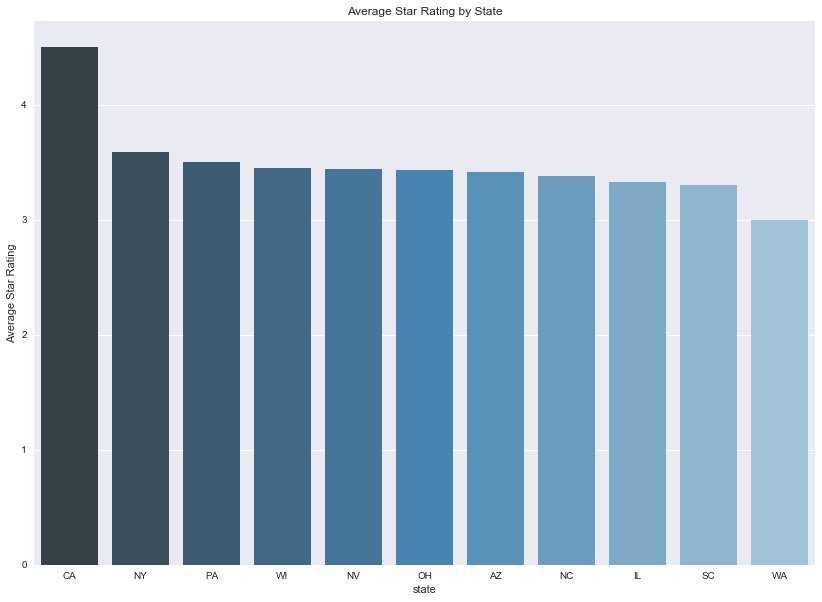

In [8]:
# average star rating by state
statemeans_df = restaurant_df.groupby('state', as_index=False)['stars'].mean()
statemeans_df = statemeans_df.sort_values(by=['stars'], ascending=False)
states = [ "AK","AL","AR","AS","AZ","CA","CO","CT","DC","DE","FL","GA","GU","HI","IA","ID","IL","IN",
"KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY","OH",
"OK","OR","PA","PR","RI","SC","SD","TN","TX","UT","VA","VI","VT","WA","WI","WV","WY"]
statemeans_df = statemeans_df[statemeans_df['state'].isin(states)]
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(x='state',y='stars',palette="Blues_d", data=statemeans_df)
ax.set_ylabel('Average Star Rating')
ax.set_title('Average Star Rating by State')

C:\Users\ikhoon\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


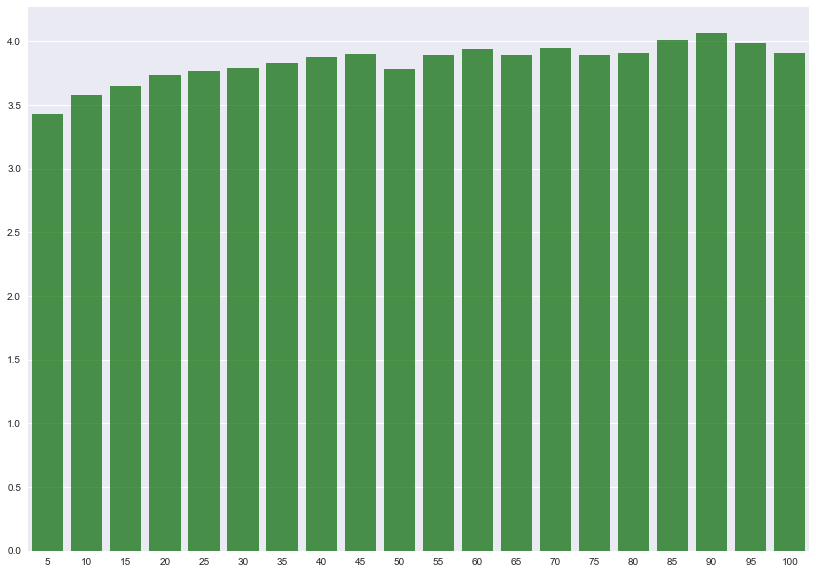

In [9]:
# average star rating by review count
numbermeans_df = restaurant_df.groupby('review_count', as_index=False)['stars'].mean()
#plt.plot(numbermeans_df['review_count'], numbermeans_df['stars'])

slices = np.linspace(0, len(numbermeans_df), len(numbermeans_df)/45+1, True).astype(np.int)
counts = np.diff(slices)
mean = np.add.reduceat(numbermeans_df['stars'], slices[:-1]) / counts
fig, ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x=[x*10 for x in range(len(mean))], y=mean, color = 'green', alpha=0.75)
ax.set(xticklabels = [(x+1)*5 for x in range(21)]);

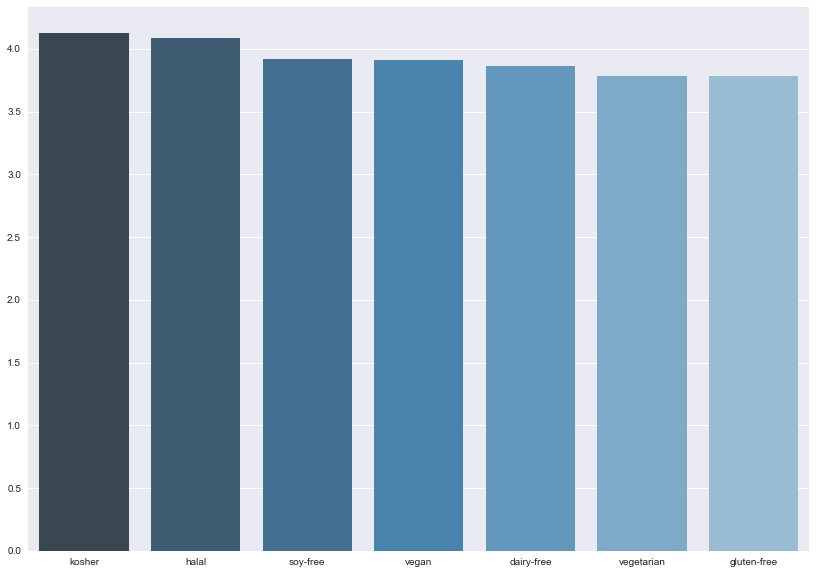

In [10]:
# average rating by dietary restrictions
dietary_headers = restaurant_df.columns[34:41]
dietary_dict={}

for item in dietary_headers:
    trimmed_name = item[31:]
    dietary_dict[trimmed_name] = restaurant_df.loc[restaurant_df[item] == True, 'stars'].mean()

pairs = zip(list(dietary_dict.keys()), list(dietary_dict.values()))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
dietaryrestrictions, means = zip(*pairs)
fig, ax = plt.subplots(figsize=(14,10))
ax=sns.barplot(x=dietaryrestrictions, y=means, palette='Blues_d')

In [11]:
def create_pivot_restaurant(df, cat):
    sub_df = df[[cat,'stars']]
    pivot = pd.pivot_table(sub_df,index=[cat], aggfunc=np.sum) 
    pivot['TOTAL_COUNT'] = sub_df[cat].value_counts() 
    pivot['AVG_RATING'] = pivot['stars']/pivot['TOTAL_COUNT'] 
    return pivot

In [12]:
# average rating by alcohol type
d = create_pivot_restaurant(restaurant_df, 'attributes.Alcohol')
d

,stars,TOTAL_COUNT,AVG_RATING
attributes.Alcohol,,,
beer_and_wine,21917.5,6066,3.613172
full_bar,55407.5,15853,3.495080
none,63020.5,18316,3.440735


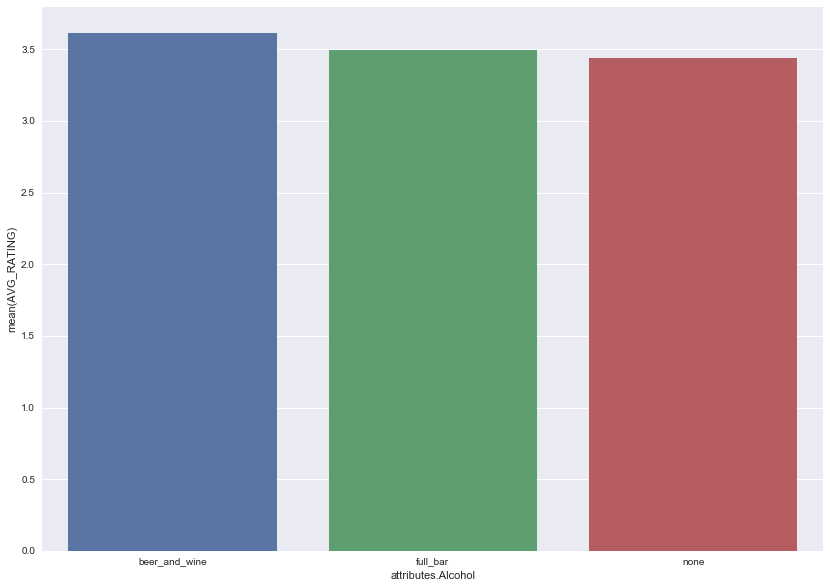

In [13]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(d.index, d['AVG_RATING'], ax = ax)

In [14]:
# average rating by attire
d = create_pivot_restaurant(restaurant_df, 'attributes.RestaurantsAttire')
d

,stars,TOTAL_COUNT,AVG_RATING
attributes.RestaurantsAttire,,,
casual,149545.5,43276,3.455622
dressy,5207.0,1397,3.727273
formal,413.5,125,3.308000


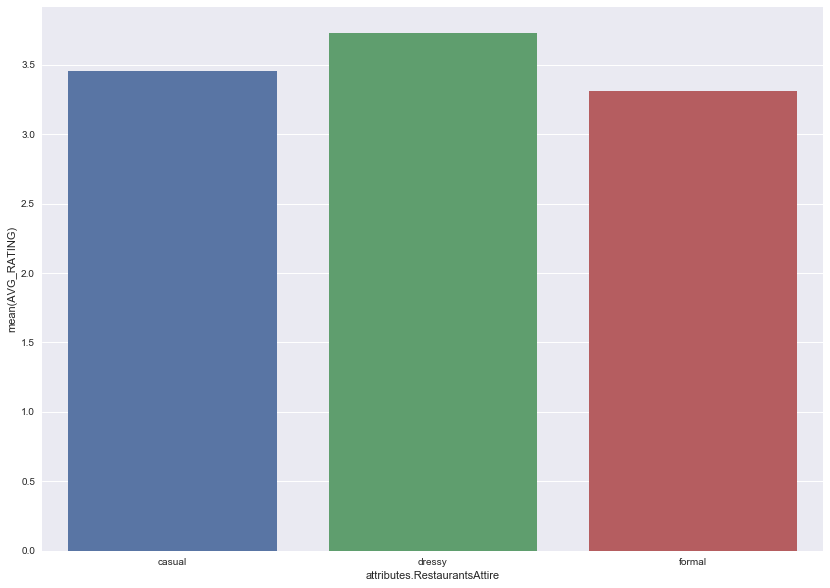

In [15]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(d.index, d['AVG_RATING'], ax = ax)

In [16]:
# average rating by pricerange
r = create_pivot_restaurant(restaurant_df, 'attributes.RestaurantsPriceRange2')
r

,stars,TOTAL_COUNT,AVG_RATING
attributes.RestaurantsPriceRange2,,,
1.0,65102.5,19013,3.424105
2.0,86878.5,24919,3.486436
3.0,10331.5,2845,3.631459
4.0,1998.0,537,3.720670


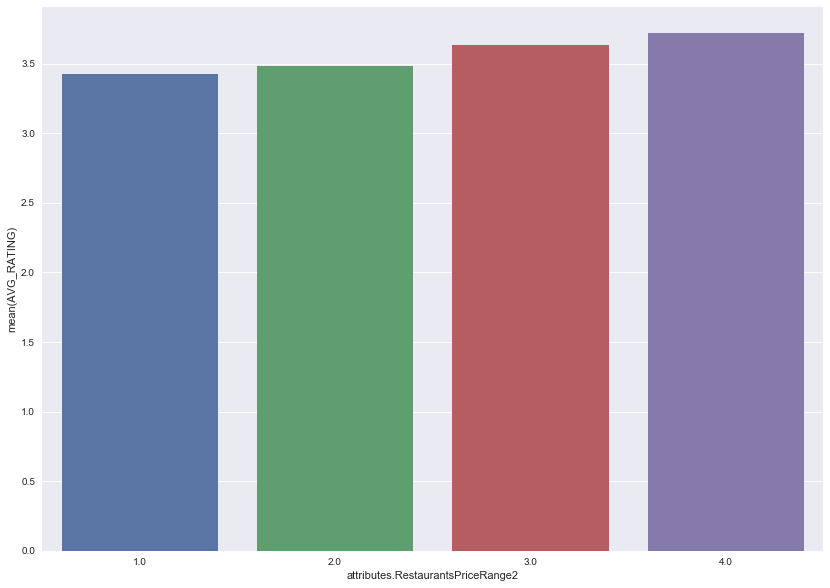

In [17]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(r.index, r['AVG_RATING'], ax = ax);

In [18]:
ambience_ratings = {}
for a in ['attributes.Ambience.casual', 'attributes.Ambience.classy', 'attributes.Ambience.divey',
          'attributes.Ambience.hipster', 'attributes.Ambience.intimate', 'attributes.Ambience.romantic',
          'attributes.Ambience.touristy', 'attributes.Ambience.trendy', 'attributes.Ambience.upscale']:
    ambience_ratings[a] =  create_pivot_restaurant(restaurant_df, a).iloc[1]

In [19]:
ambience_df = pd.DataFrame.from_dict(ambience_ratings, orient = 'index')
ambience_df

,stars,TOTAL_COUNT,AVG_RATING
attributes.Ambience.casual,64843.5,18166.0,3.569498
attributes.Ambience.classy,3123.5,821.0,3.804507
attributes.Ambience.divey,3012.5,838.0,3.594869
attributes.Ambience.hipster,3186.0,818.0,3.894866
attributes.Ambience.intimate,1985.5,508.0,3.908465
attributes.Ambience.romantic,1904.5,499.0,3.816633
attributes.Ambience.touristy,553.5,180.0,3.075000
attributes.Ambience.trendy,6536.0,1741.0,3.754164
attributes.Ambience.upscale,1338.5,349.0,3.835244


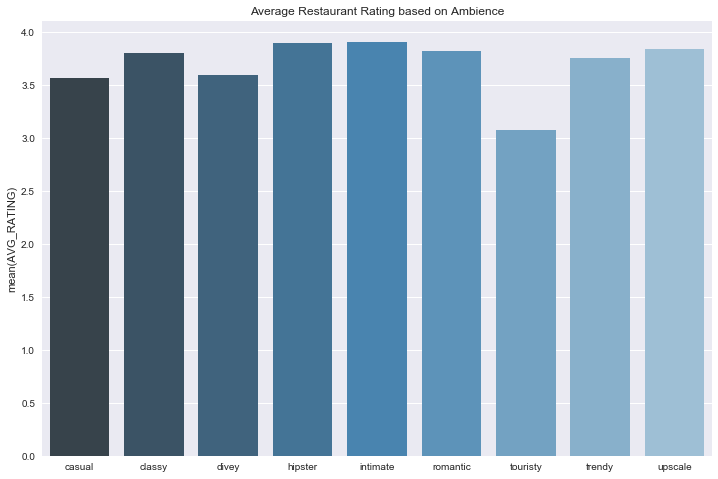

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
index = [x.split('.')[2] for x in ambience_df.index]
sns.barplot(index, ambience_df['AVG_RATING'], ax = ax, palette = "Blues_d")
ax.set_title('Average Restaurant Rating based on Ambience');

In [21]:
parking_ratings = {}
for a in ['attributes.BusinessParking.garage', 'attributes.BusinessParking.lot', 'attributes.BusinessParking.street',
          'attributes.BusinessParking.valet', 'attributes.BusinessParking.validated']:
    parking_ratings[a] =  create_pivot_restaurant(restaurant_df, a).iloc[1]
parking_df = pd.DataFrame.from_dict(parking_ratings, orient = 'index')
parking_df

,stars,TOTAL_COUNT,AVG_RATING
attributes.BusinessParking.garage,7593.5,2171.0,3.497697
attributes.BusinessParking.lot,58328.0,16437.0,3.548579
attributes.BusinessParking.street,32030.5,8676.0,3.691851
attributes.BusinessParking.valet,3769.5,1039.0,3.628008
attributes.BusinessParking.validated,862.5,238.0,3.623950


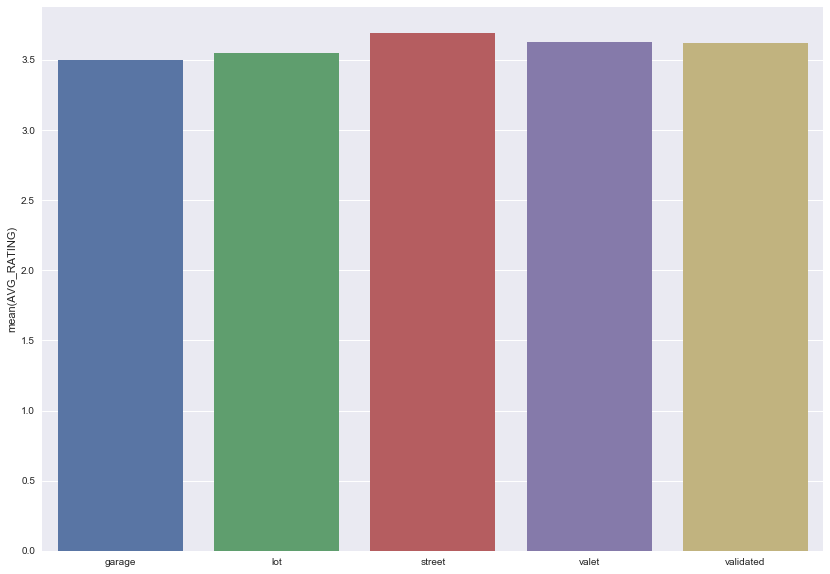

In [22]:
fig, ax = plt.subplots(figsize=(14,10))
index = [x.split('.')[2] for x in parking_df.index]
sns.barplot(index, parking_df['AVG_RATING'], ax = ax);

In [23]:
drivethru = create_pivot_restaurant(restaurant_df, 'attributes.DriveThru')
drivethru

,stars,TOTAL_COUNT,AVG_RATING
attributes.DriveThru,,,
False,12276.5,3686,3.330575
True,6171.0,2352,2.623724


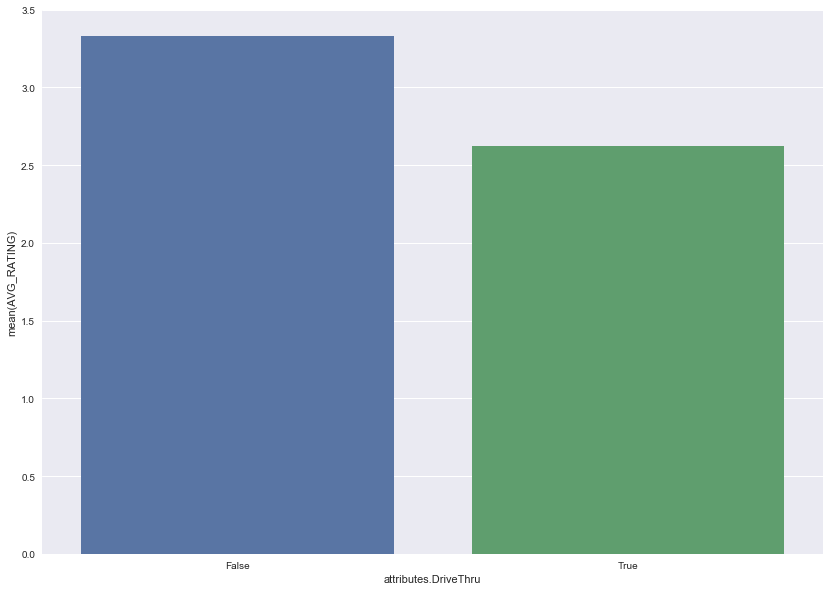

In [24]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(drivethru.index, drivethru['AVG_RATING'])

In [25]:
create_pivot_restaurant(restaurant_df, 'attributes.GoodForKids')

,stars,TOTAL_COUNT,AVG_RATING
attributes.GoodForKids,,,
False,26598.0,7640,3.481414
True,130648.0,37796,3.456662


In [26]:
good_for_meals = {}
for a in ['attributes.GoodForMeal.breakfast', 'attributes.GoodForMeal.brunch', 
          'attributes.GoodForMeal.dessert', 'attributes.GoodForMeal.dinner', 'attributes.GoodForMeal.latenight',
          'attributes.GoodForMeal.lunch', 'attributes.HappyHour']:
    good_for_meals[a] =  create_pivot_restaurant(restaurant_df, a).iloc[1]
    
good_for_meals_df = pd.DataFrame.from_dict(good_for_meals, orient = 'index')
good_for_meals_df

,stars,TOTAL_COUNT,AVG_RATING
attributes.GoodForMeal.breakfast,12970.0,3722.0,3.484686
attributes.GoodForMeal.brunch,12790.5,3549.0,3.603973
attributes.GoodForMeal.dessert,5325.0,1513.0,3.519498
attributes.GoodForMeal.dinner,54958.5,15299.0,3.592294
attributes.GoodForMeal.latenight,8282.5,2473.0,3.349171
attributes.GoodForMeal.lunch,63607.5,17817.0,3.570045
attributes.HappyHour,14500.0,4185.0,3.464755


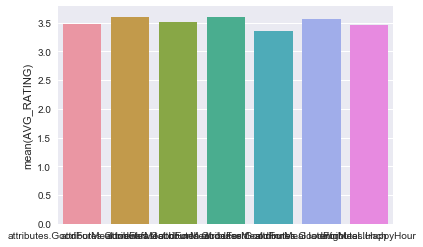

In [27]:
sns.barplot(good_for_meals_df.index, good_for_meals_df['AVG_RATING'])

## Part 1: Create a Baseline

### Creating training, validating, and testing sets

In [28]:
# take 100000 reviews as sample
data_array = (np.random.choice(restaurant_reviews, size = 100000))
data_set = list(data_array)

As the dataset is so large, we had to take a subset of it to work with because of technical limitations of our computers.

In [29]:
# find all categories for one-hot encoding purposes
from collections import Counter
all_categories = []
for r in restaurant_data:
    if 'Restaurants' in r['categories']:
        for c in r['categories']:
            all_categories.append(c)

In the original dataset, "categories" is given as a list in each cell. We found all the unique categories here (e.g. French, Burgers, etc.).

In [30]:
# take 150 most popular categories
counts = list (Counter(all_categories).items())
counts.sort(key=lambda x: x[1], reverse = True)
most_popular = [x[0] for x in counts[:150]]

Many of the categories were either inappropriate (e.g. laundry) or too rare to be useful. Here, we narrowed down the categories to the top 150.

In [31]:
# create restaurant and user dictionaries for easy lookup
restaurant_dict = {}
for item in restaurant_data:
    restaurant_id = item['business_id']
    restaurant_dict[restaurant_id] = item

user_dict = {}
for item in user_data:
    user_id = item['user_id']
    user_dict[user_id] = item

In [32]:
# make copy of the reviews array
expanded_reviews = copy.deepcopy(data_array)

In [33]:
# add business and user info
for review in expanded_reviews:
    #print (review)
    restaurant = review['business_id']
    user = review['user_id']
    restaurant_info = restaurant_dict[restaurant]
    #print (restaurant_info)
    user_info = user_dict[user]
    for attribute in restaurant_info:
        #print (attribute)
        if attribute not in ['is_open', 'latitude','longitude','name','business_id',
                             'neighborhood','address','city','postal_code','hours']:
            if attribute == 'categories':
                for c in most_popular:
                    if c in restaurant_info[attribute]:
                        review['R_' +  c] = 1
                    else:
                        review['R_' +  c] = 0
            else:         
                review['R_' + attribute] = restaurant_info[attribute]
    for attribute in user_info:
        if attribute not in ['user_id','name']:   
            if attribute == 'friends':
                review['U_friends'] = len(user_info[attribute])
            elif attribute == 'yelping_since':
                review['U_yelping_since'] = user_info[attribute][:4]
            elif attribute == 'elite':
                if user_info[attribute]:
                    review['U_elite'] = True
                else:
                    review['U_elite'] = False        
            else:
                review['U_' + attribute] = user_info[attribute] 

Here, we added user and business attributes to the reviews dictionary.

In [34]:
# create pandas dataframe
flatframe = json_normalize(expanded_reviews)
flatframe = flatframe.drop(['text','useful','funny','cool','date'], axis=1)

In [35]:
# change user since
flatframe['U_years_yelping'] = [2015 - int(x) for x in flatframe['U_yelping_since']]
flatframe.drop(['U_yelping_since'],axis = 1, inplace = True)

We decided to change "U_yelping_since", which was a year, to the number of years a user has been active (so that it would make more sense as a continuous variable).

In [36]:
# drop ids
flatframe_wids = flatframe.drop(['business_id', 'review_id', 'user_id'], axis = 1)

This was just for convenience when performing regression later==we didn't want to use the drop function every time we referred to the dataframe.

In [37]:
#one hot encode
flatframe_wids = pd.get_dummies(flatframe_wids, columns = ['R_state', 
                                                    'R_attributes.Alcohol', 'R_attributes.AgesAllowed', 'R_attributes.RestaurantsAttire',
                                                    'R_attributes.RestaurantsPriceRange2','R_attributes.Smoking',
                                                    'R_attributes.WiFi', 'R_attributes.NoiseLevel','R_attributes.BYOBCorkage'])

In [38]:
# drop column if more than half of a column is nan
nan_count = {}
for column in flatframe_wids:
     nan_count[column] = flatframe_wids[column].isnull().sum()

nan_sorted = sorted(nan_count.items(), key=lambda x: x[1], reverse = True) 
drop_nans = [x[0] for x in nan_sorted if x[1] > 50000]

In [39]:
# drop some nans and fill some nans
flatframe_wids = flatframe_wids.drop(drop_nans, axis = 1)
flatframe_wids = flatframe_wids.fillna(flatframe_wids.mean())

There were many attributes with an unusually large number of NaNs (not 0 or False). We used mean imputation for many of these, but if more than half of the rows had missing values, we felt uncomfortable doing so and decided to drop the column entirely instead.

In [40]:
# train test split
msk = np.random.rand(len(flatframe_wids)) < 0.5
data_train = flatframe_wids[msk]
data_test = flatframe_wids[~msk]

### Getting global averages

In [41]:
# make pandas dataframe for user data
user_df = json_normalize(user_data)

In [42]:
# train test split including business ids and user ids
data_train_temp = flatframe[msk]
data_test_temp = flatframe[~msk]

For this part of the project, we needed to include business and user ids for lookup purposes, which we had earlier deleted.

In [43]:
# global user average
users = data_train_temp.user_id.unique()
user_total = user_df[user_df['user_id'].isin(users)]['average_stars']
global_user_average = sum(user_total)/len(user_total)
print (global_user_average)

3.73744539253


In [44]:
# global restaurant average
restaurants = data_train_temp.business_id.unique()
restaurant_total = restaurant_df[restaurant_df['business_id'].isin(restaurants)]['stars']
global_restaurant_average = sum(restaurant_total)/len(restaurant_total)
print (global_restaurant_average)

3.5691960774


In [45]:
# global review average
global_review_average = data_train['stars'].mean()
print (global_review_average)

3.7128174365126974


The "global user average" takes a single user and his/her average rating given as one data point. The 'global restaurant average' does the same with individual restaurants. The 'global review average' averages every rating from every review. These are different values as each individual rating is weighted differently in each method.

### Getting restaurant and user biases

In [46]:
# user biases
user_deviations = {}
for item in user_data:
    user_id = item['user_id']
    user_deviations[user_id] = item['average_stars'] - global_user_average

In [47]:
# restaurant biases
restaurant_deviations = {}
for item in restaurant_data:
    rest_id = item['business_id']
    restaurant_deviations[rest_id] = item['stars'] - global_restaurant_average

We decided to use the global user average and the global restaurant average for the user and restaurant bias calculation respectively (rather than global review average for everything) because we felt that it was most appropriate to compare a user's average rating to other users and a restaurant's average rating to other restaurants rather than to an average of all reviews.

### Baseline Model

In [51]:
# creating xy variables
Xtrain = data_train.drop(['stars'], axis = 1)
ytrain = data_train['stars']
Xtest = data_test.drop(['stars'], axis = 1)
ytest = data_test['stars']

In [52]:
def baseline(user_id, business_id):
    pred = global_review_average + user_deviations[user_id] + restaurant_deviations[business_id]
    return int(round(pred))

In [53]:
# predictions
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]

In [54]:
print ("The accuracy score of the baseline model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, base_pred)))
print ("The accuracy score of the baseline model on the test set is {}"
       .format(metrics.accuracy_score(ytest, base_pred_test)))

The accuracy score of the baseline model on the train set is 0.3932413517296541
The accuracy score of the baseline model on the test set is 0.38885777155431084


In [100]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : base_pred})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : base_pred_test})

base_pred_avg = []
base_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    base_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    base_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

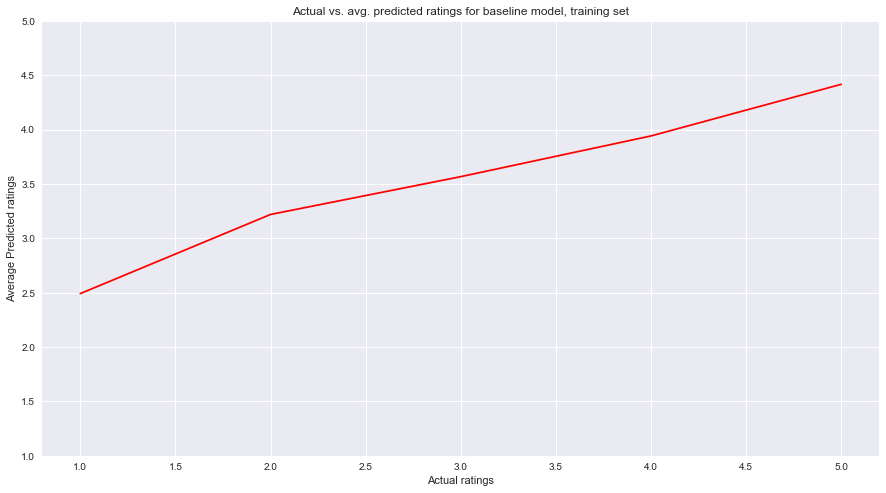

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], base_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for baseline model, training set')
ax.set_ylim((1,5))

(1, 5)

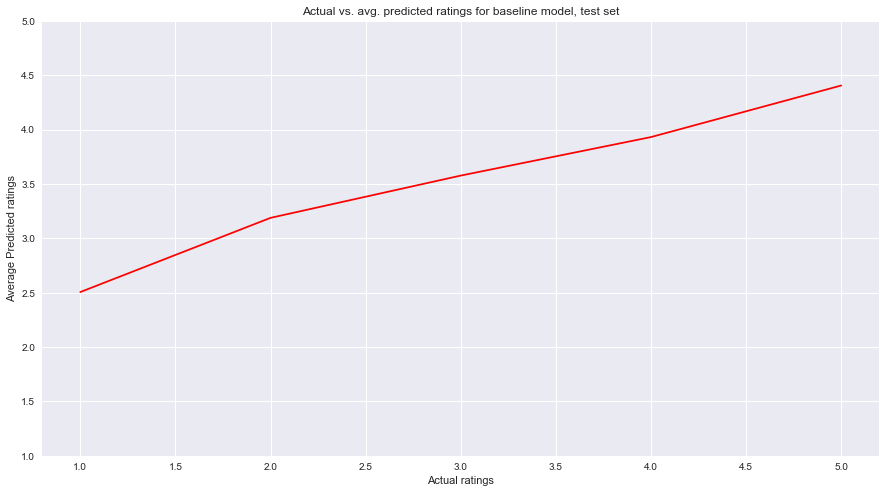

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], base_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for baseline model, test set')
ax.set_ylim((1,5))

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings.

## Part 2: Create a Regularized Regression

### Linear Model

In [55]:
model = LinearRegression()
model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We used a linear model rather than a logistic model as although the y-varaible was categorical (1, 2, 3, 4, or 5), it was ordinal.

In [56]:
ypred = model.predict(Xtrain)
ypred_test = model.predict(Xtest)
predround = [int(round(x)) for x in ypred]
print ("The accuracy score of the linear model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, predround)))
predround_test = [int(round(x)) for x in ypred_test]
print ("The accuracy score of the linear model on the test set is {}"
       .format(metrics.accuracy_score(ytest, predround_test)))

The accuracy score of the linear model on the train set is 0.38662267546490703
The accuracy score of the linear model on the test set is 0.3810962192438488


Here, we round the predictions from the model to the nearest integer to fit the predictions in the categories (1, 2, 3, 4, or 5).

### Lasso CV

In [60]:
model_lasso = LassoCV().fit(Xtrain, ytrain)

In [61]:
lasso_ypred = model_lasso.predict(Xtrain)
lasso_ypred_round = [int(round(x)) for x in lasso_ypred]
lasso_ypred_test = model_lasso.predict(Xtest)
lasso_ypred_test_round = [int(round(x)) for x in lasso_ypred_test]

In [62]:
print ("The accuracy score of the lasso model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, lasso_ypred_round)))
print ("The accuracy score of the lasso model on the test set is {}"
       .format(metrics.accuracy_score(ytest, lasso_ypred_test_round)))

The accuracy score of the lasso model on the train set is 0.3672265546890622
The accuracy score of the lasso model on the test set is 0.36415283056611325


### Ridge CV

In [57]:
model_ridge = RidgeCV().fit(Xtrain, ytrain)

In [58]:
ridge_ypred = model_ridge.predict(Xtrain)
ridge_ypred_round = [int(round(x)) for x in ridge_ypred]
ridge_ypred_test = model_ridge.predict(Xtest)
ridge_ypred_test_round = [int(round(x)) for x in ridge_ypred_test]

In [59]:

print ("The accuracy score of the ridge model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ridge_ypred_round)))
print ("The accuracy score of the ridge model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ridge_ypred_test_round)))

The accuracy score of the ridge model on the train set is 0.3862627474505099
The accuracy score of the ridge model on the test set is 0.38135627125425087


We will be using the regularized linear regression using the ridge method as it performed better than the lasso method for accuracy score (and very similarly to the naive linear regression).

In [108]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ridge_ypred_round})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ridge_ypred_test_round})

ridge_pred_avg = []
ridge_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    ridge_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    ridge_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

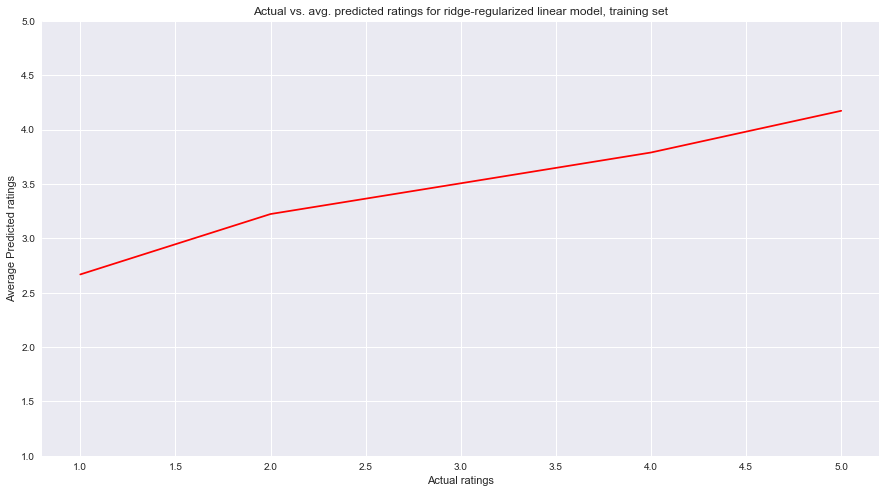

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], ridge_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for ridge-regularized linear model, training set')
ax.set_ylim((1,5))

(1, 5)

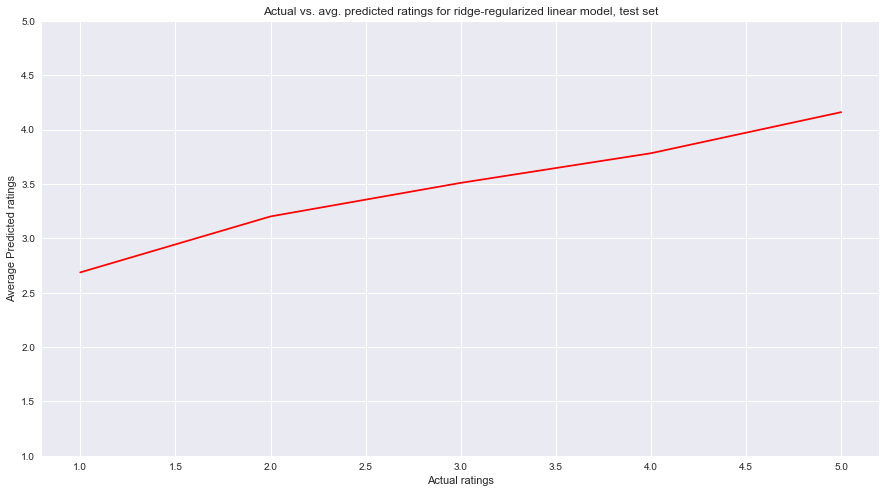

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], ridge_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for ridge-regularized linear model, test set')
ax.set_ylim((1,5))

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings and underestimate for higher ratings.

## Part 3: Matrix Factorization

## Part 4: A Different Model

### Naive kNN Model

In [63]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn.fit(Xtrain, ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

We used a KNeighborsRegressor model as we felt that a regressor was more appropriate than a classifier because although the y-variable was categorical (1, 2, 3, 4, 5), it was also ordinal.

In [64]:
ypred_train = np.round(knn.predict(Xtrain)).astype(int)
ypred_test = np.round(knn.predict(Xtest)).astype(int)

In [65]:
print ("The accuracy score of the knn model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ypred_train)))
print ("The accuracy score of the knn model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ypred_test)))

The accuracy score of the knn model on the train set is 0.35208958208358326
The accuracy score of the knn model on the test set is 0.28095619123824767


### Cross-Validation

In [66]:
from sklearn.model_selection import KFold
means = []

for i in range(1, 11):
    knn = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)
    n_folds=5
    fold = 0
    
    valid_acc = [0, 0, 0, 0, 0]
    for train, valid in KFold(n_folds, shuffle=True).split(range(len(Xtrain))):
        train_set = data_train.iloc[train]
        valid_set = data_train.iloc[valid]
        
        X_cross_train = train_set.drop(['stars'], axis = 1)
        y_cross_train = train_set['stars']
        X_cross_valid = valid_set.drop(['stars'], axis = 1)
        y_cross_valid = valid_set['stars']

        knn.fit(X_cross_train, y_cross_train)
        
        y_hat_train_cross = np.round(knn.predict(X_cross_train)).astype(int)
        y_hat_valid_cross = np.round(knn.predict(X_cross_valid)).astype(int)
        
        valid_acc[fold] = metrics.accuracy_score(y_cross_valid, y_hat_valid_cross)
        fold += 1
    print(str(i) + ', ' + str(np.mean(valid_acc)))
    means.append(np.mean(valid_acc))
    
k = (means.index(np.max(means)) + 1)
print(str(k) + " = k model has highest mean validation accuracy score at: " + str(np.max(means)))

1, 0.321295740852
2, 0.290061987602
3, 0.289662067586
4, 0.28600279944
5, 0.279764047191
6, 0.275964807039
7, 0.274945010998
8, 0.272985402919
9, 0.268126374725
10, 0.268326334733
1 = k model has highest mean validation accuracy score at: 0.321295740852


Here, we had to hard-code cross-validation (rather than using cross_val_score because the default scoring method for kNeighborsRegressor was r2, and we wanted to use classification accuracy. The mean validation accuracy consistently decreases as k increases-- k=1 is the best-performing model.

### Final kNN Model

In [67]:
knn = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
knn.fit(Xtrain, ytrain)
ypred_train = np.round(knn.predict(Xtrain)).astype(int)
ypred_test = np.round(knn.predict(Xtest)).astype(int)
print ("The accuracy score of the knn model on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ypred_train)))
print ("The accuracy score of the knn model on the test set is {}"
       .format(metrics.accuracy_score(ytest, ypred_test)))

The accuracy score of the knn model on the train set is 0.9999400119976005
The accuracy score of the knn model on the test set is 0.327125425085017


It is interesting that the highest performing model has k=1--this was true in both cross-validation and when looking at test accuracies separately (code not shown here for test accuracies of other models). This suggests that for a given user-restaurant combination, the single user-restaurant combination already in the dataset that is closest to the desired combination is most reflective of the desired combination (rather than an aggregate of several close combinations). Furthermore, this model has a relatively lower test accuracy than the baseline and the regression models, suggesting that it is not the best model to use for this dataset. Cross-validation did increase the accuracy score from the naive model (which used k = 5 as default).

In [111]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ypred_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ypred_test})

knn_pred_avg = []
knn_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    knn_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    knn_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

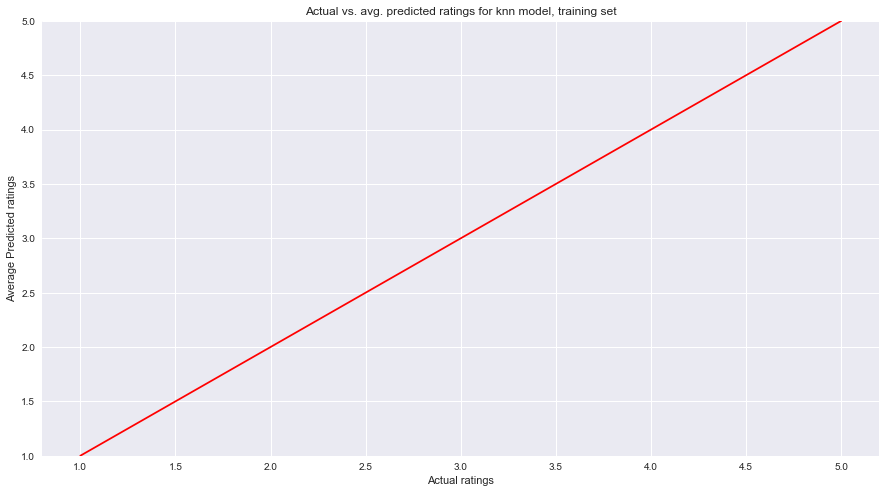

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], knn_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for knn model, training set')
ax.set_ylim((1,5))

(1, 5)

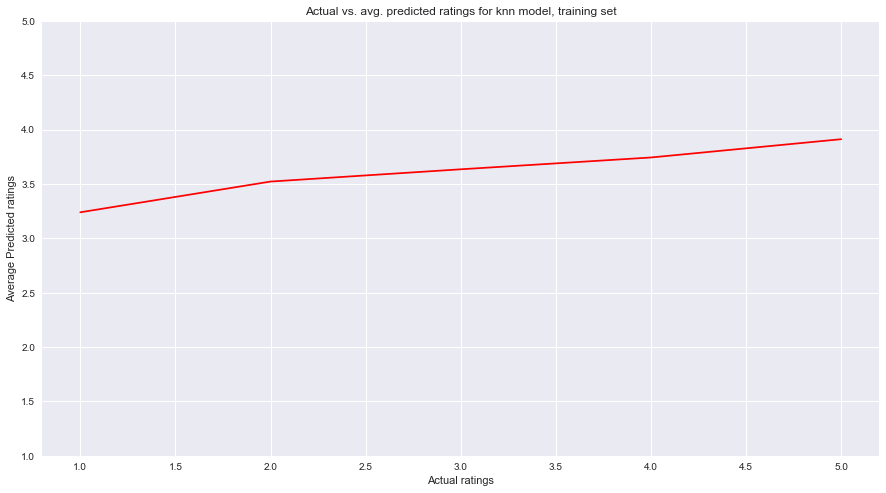

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], knn_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for knn model, training set')
ax.set_ylim((1,5))

As k=1, the training set has a perfect match between actual ratings and predicted ratings. For the test set, however, the average predicted ratings start at around 3.25 when the actual ratings are 1 and increase slightly to about 3.75 when the actual ratings are 5 (much flatter graph than the other models).

## Part 5: Ensemble Method

### Majority Vote Model

In [85]:
from collections import Counter
predictions_train = []
predictions_test = []
counter_predictions_train = []
counter_predictions_test = []

# all the predictions in one place
base_pred = [baseline(x,y) for x,y in zip(data_train_temp['user_id'],data_train_temp['business_id'])]
base_pred_test = [baseline(x,y) for x,y in zip(data_test_temp['user_id'],data_test_temp['business_id'])]
ridge_ypred_round = [int(round(x)) for x in ridge_ypred]
ridge_ypred_test_round = [int(round(x)) for x in ridge_ypred_test]
#matrix factorization train
#matrix factorization test
knn_pred_train = np.round(knn.predict(Xtrain)).astype(int)
knn_pred_test = np.round(knn.predict(Xtest)).astype(int)

for i in range(len(ytrain)):
    temp = []
    temp.append(base_pred[i])
    temp.append(ridge_ypred_round[i])
    #temp.append(matrix factorization train)
    temp.append(knn_pred_train[i])
    counter_predictions_train.append(Counter(temp))
    predictions_train.append(temp)
    
for i in range(len(ytest)):
    temp = []
    temp.append(base_pred_test[i])
    temp.append(ridge_ypred_test_round[i])
    #temp.append(matrix factorization test)
    temp.append(knn_pred_test[i])
    counter_predictions_test.append(Counter(temp))
    predictions_test.append(temp)

In [86]:
# majority votes
ensemble_pred_train = []
ensemble_pred_test = []

for i in range(len(counter_predictions_train)):
    value, count = counter_predictions_train[i].most_common()[0]
    ensemble_pred_train.append(value)
    
for i in range(len(counter_predictions_test)):
    value, count = counter_predictions_test[i].most_common()[0]
    ensemble_pred_test.append(value)

In [87]:
print ("The accuracy score of the ensemble model (majority vote) on the train set is {}"
       .format(metrics.accuracy_score(ytrain, ensemble_pred_train)))
print ("The accuracy score of the ensemble model (majority vote) on the test set is {}"
       .format(metrics.accuracy_score(ytest, ensemble_pred_test)))

The accuracy score of the ensemble model (majority vote) on the train set is 0.47726454709058186
The accuracy score of the ensemble model (majority vote) on the test set is 0.39947989597919586


This ensemble method predicts by taking a majority vote of every model's prediction for a given predictor set. This improves upon all the models--both training and test accuracies are higher than any individual component model of the ensemble model (excluding training accuracy for kNN, which was 1 because k = 1).}

In [115]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : ensemble_pred_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : ensemble_pred_test})

majority_pred_avg = []
majority_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    majority_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    majority_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

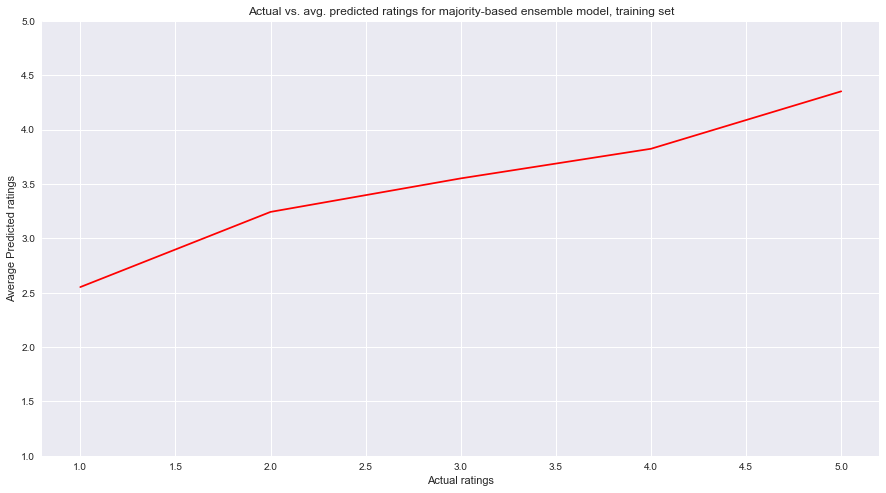

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], majority_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for majority-based ensemble model, training set')
ax.set_ylim((1,5))

(1, 5)

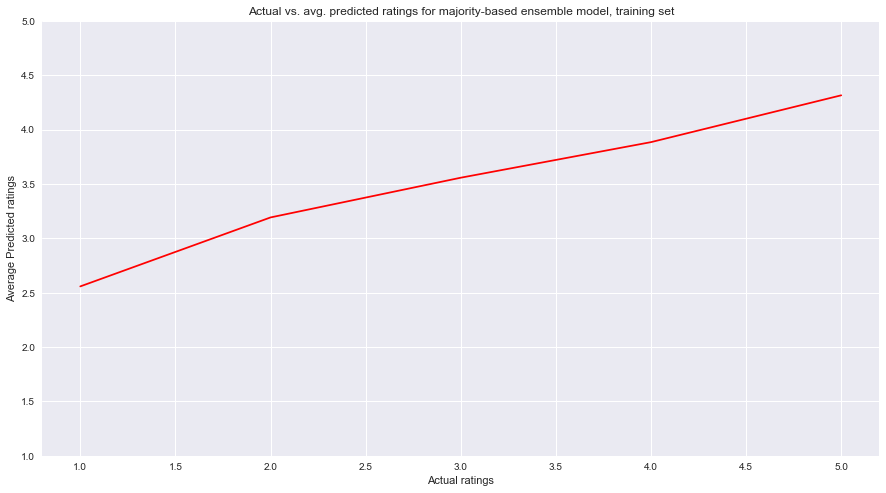

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], majority_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for majority-based ensemble model, training set')
ax.set_ylim((1,5))

On average, our predictions for both the training and the test set follow the increasing trend of actual ratings but overestimate for lower ratings.

### Ensemble Method Using Logistic Regression

In [88]:
# logistic regression metaclassifier
logreg = LogisticRegressionCV()
y_hat_test = logreg.fit(predictions_train, ytrain).predict(predictions_test)
y_hat_train = logreg.fit(predictions_train, ytrain).predict(predictions_train)

print("Train LogReg: ", metrics.accuracy_score(ytrain, y_hat_train))
print("Test LogReg: ", metrics.accuracy_score(ytest, y_hat_test))

Train LogReg:  0.76050789842
Test LogReg:  0.362692538508


This model performed significantly better on the training set; however, it actually performed *worse* on the test set. This may be because of the kNN model being weighted more because of its high training accuracy due to its parameter k being 1.

In [118]:
# calculate averages
pred_df_train = pd.DataFrame({'y' : ytrain, 'ypred' : y_hat_train})
pred_df_test = pd.DataFrame({'y' : ytest, 'ypred' : y_hat_test})

log_pred_avg = []
log_pred_test_avg = []
for i in [1, 2, 3, 4, 5]:
    log_pred_avg.append(pred_df_train[pred_df_train['y'] == i]['ypred'].mean())
    log_pred_test_avg.append(pred_df_test[pred_df_test['y'] == i]['ypred'].mean())

(1, 5)

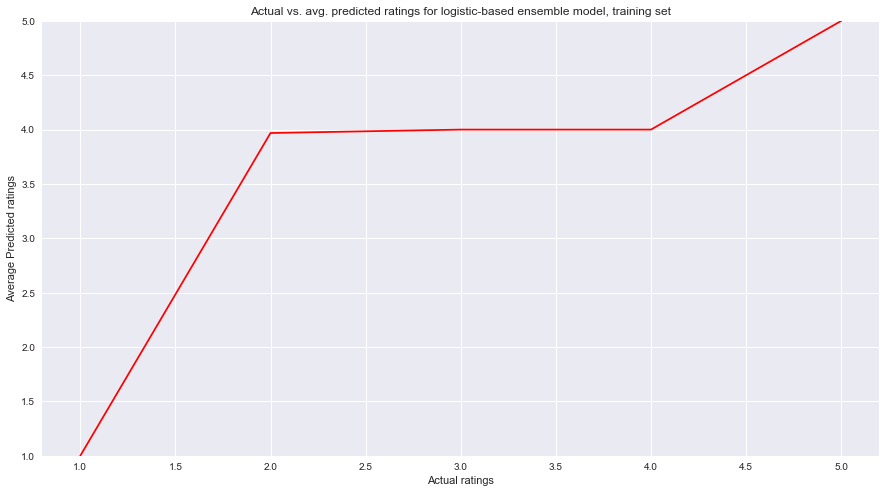

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], log_pred_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for logistic-based ensemble model, training set')
ax.set_ylim((1,5))

(1, 5)

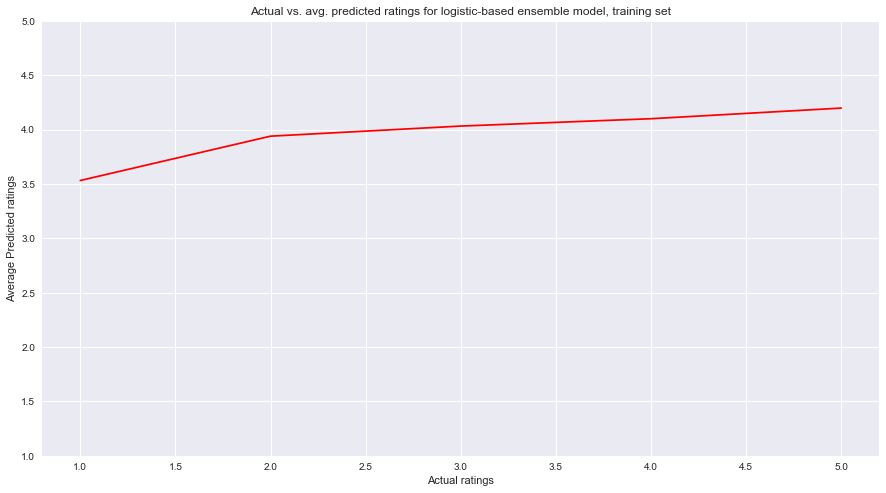

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], log_pred_test_avg, color='red')

ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for logistic-based ensemble model, training set')
ax.set_ylim((1,5))

For the training set, the model performed well for when actual ratings were 1, 4, and 5 (not 2 and 3). The line was very flat for the test set, reflecting the large influence that the knn model had using this ensemble method.